<a href="https://colab.research.google.com/github/CyScar/Chembio_hack/blob/main/ChemBio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Installing dependencies

In [1]:
!pip install Bio
!pip install scikit-bio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.6/278.6 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 12.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 9.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 74.0 MB/s eta 0:00:00
  Created wheel for scikit-bio: filename=scikit_bio-0.5.9-cp310-cp310-linux_x86_64.whl size=2469062 sha256=6629fbeaee2007b0ffb5f90963c1adff1ecb60b8efb1fada67ddf4dd5efdc0a0
  Stored in directory: /root/.cache/pip/wheels/77/72/2c/993efbb4d69a86bee422bc96e4e2f1ec9af7cc596a08bb86e1
  Created

In [85]:
import numpy as np
import pandas as pd
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from Bio.motifs.matrix import PositionSpecificScoringMatrix
from skbio import Protein
from skbio.stats import composition
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

#Data Preprocessing

In [3]:
def unq_val(file_path):
  with open(file_path, 'r') as f:
    unique = [line.strip() for line in f.readlines()]
  return unique

In [4]:
nmain1 = unq_val("nmain1.txt")
nmain2 = unq_val("nmain2.txt")
nindep1 = unq_val("nindep1.txt")
nindep2 = unq_val("nindep2.txt")
pmain1= unq_val("pmain1.txt")
pindep1 = unq_val("pindep1.txt")

In [30]:
negative_data = len(nmain1 + nmain2 + nindep1 + nindep2)
positive_data = len(pmain1 + pindep1)
print("Number of positive sequences: ", positive_data)
print("Number of negative sequences: ", negative_data)

Number of positive sequences:  2108
Number of negative sequences:  17434


In [31]:
train_seq = pmain1 + nmain1 + nmain2
train_label = [1]*len(pmain1) + [0]*len(nmain1 + nmain2)

val_seq = pindep1 + nindep1 + nindep2
val_label = [1]*len(pindep1) + [0]*len(nindep1 + nindep2)

#Feature Extraction

In [39]:
kyte_doolittle_hydropathy = {                   #kyte_doolittle_hydropathy used to calculate gravy score
    'A': 1.8, 'R': -4.5, 'N': -3.5, 'D': -3.5, 'C': 2.5,
    'Q': -3.5, 'E': -3.5, 'G': -0.4, 'H': -3.2, 'I': 4.5,
    'L': 3.8, 'K': -3.9, 'M': 1.9, 'F': 2.8, 'P': -1.6,
    'S': -0.8, 'T': -0.7, 'W': -0.9, 'Y': -1.3, 'V': 4.2
}

def calculate_gravy(seq):                       #Calculates the Gravy score of the sequence
    sequence = seq.upper()
    gravys = [kyte_doolittle_hydropathy[a] for a in sequence if a in kyte_doolittle_hydropathy]
    return sum(gravys) / len(gravys) if gravys else 0.0

def gc_cont(seq):                               #Calculates the GC content of the sequence
    gc_count = seq.count("G") + seq.count("C")
    Base_len = seq.count("A") + seq.count("T") + seq.count("G") + seq.count("C")
    if Base_len == 0:
      gc_content = 0
    else:
      gc_content = (gc_count/Base_len)*100
    return gc_content

def bio_features(seq):                          #Calculates the Amino Acid Composition, Physical Structure fractions, Molecular weight and returns a dictionary of all the features.
    analyzed_seq = ProteinAnalysis(seq)
    seq1 = Protein(seq)

    amino_acid_comp = analyzed_seq.get_amino_acids_percent()
    secondary_structure_frac = analyzed_seq.secondary_structure_fraction()
    secondary_structures = {'Helix': secondary_structure_frac[0], 'Turn': secondary_structure_frac[1], 'Sheet': secondary_structure_frac[2] }
    physiochem_properties = {
        'molecular_weight': analyzed_seq.molecular_weight(),
        'aromaticity': analyzed_seq.aromaticity(),
        'instability_index': analyzed_seq.instability_index(),
        'isoelectric_point': analyzed_seq.isoelectric_point()
    }
    kmer_freqs = seq1.kmer_frequencies(3, overlap=False)
    gravy_score = calculate_gravy(seq)

    features_dict = {
        'Amino_Acid_Composition_Q' : amino_acid_comp['Q'],
        'Amino_Acid_Composition_R' : amino_acid_comp['R'],
        'Amino_Acid_Composition_C' : amino_acid_comp['C'],
        'Helix_Fraction': secondary_structure_frac[0],
        'Turn_Fraction': secondary_structure_frac[1],
        'Sheet_Fraction': secondary_structure_frac[2],
        'Molecular_Weight': physiochem_properties['molecular_weight'],
        'GC Content' : gc_cont(seq),
        'Gravy Score' : gravy_score
    }
    return features_dict

def create_dataframe(sequences, labels):        #Runs the bio_features function on all the sequences and returns a dataframe of all the features with label
    data = []
    for seq, label in zip(sequences, labels):
        features_dict = bio_features(seq)
        features_dict['Label'] = label
        data.append(features_dict)

    df = pd.DataFrame(data)
    return df

In [80]:
df_train = create_dataframe(train_seq, train_label)
df_val = create_dataframe(val_seq, val_label)
data = df_train.append(df_val)

<ipython-input-80-65f778028aef>:3: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [81]:
#Data after feature extraction
data

,Amino_Acid_Composition_Q,Amino_Acid_Composition_R,Amino_Acid_Composition_C,Helix_Fraction,Turn_Fraction,Sheet_Fraction,Molecular_Weight,GC Content,Gravy Score,Label
0,0.000000,0.000000,0.187500,0.562500,0.125000,0.156250,3548.7693,61.538462,-0.650000,1
1,0.000000,0.057143,0.171429,0.342857,0.285714,0.171429,4192.8509,77.777778,-1.037143,1
2,0.000000,0.032258,0.193548,0.290323,0.290323,0.193548,3341.9685,72.727273,-0.012903,1
3,0.035714,0.000000,0.142857,0.214286,0.464286,0.214286,2963.3024,62.500000,-0.332143,1
4,0.034483,0.034483,0.137931,0.206897,0.448276,0.206897,3119.4881,62.500000,-0.475862,1
...,...,...,...,...,...,...,...,...,...,...
1598,0.000000,0.000000,0.000000,0.290323,0.322581,0.419355,3106.3072,26.666667,0.006452,0
1599,0.028571,0.085714,0.000000,0.485714,0.142857,0.428571,4316.0810,33.333333,-0.425714,0
1600,0.111111,0.111111,0.000000,0.277778,0.333333,0.277778,2017.3155,50.000000,-0.694444,0
1601,0.000000,0.028571,0.000000,0.285714,0.314286,0.485714,3809.2330,27.272727,-0.354286,0


#EDA and Visualisation

In [82]:
print(f"Shape of Dataframe is: {data.shape}")
print('Datatype in Each Column\n')
pd.DataFrame(data.dtypes, columns=['Datatype']).rename_axis("Column Name")

Shape of Dataframe is: (19542, 10)
Datatype in Each Column



,Datatype
Column Name,
Amino_Acid_Composition_Q,float64
Amino_Acid_Composition_R,float64
Amino_Acid_Composition_C,float64
Helix_Fraction,float64
Turn_Fraction,float64
Sheet_Fraction,float64
Molecular_Weight,float64
GC Content,float64
Gravy Score,float64


In [83]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Amino_Acid_Composition_Q,19542.0,0.029901,0.042912,0.000000,0.000000,0.000000,0.047619,0.733333
Amino_Acid_Composition_R,19542.0,0.054646,0.063722,0.000000,0.000000,0.038462,0.083333,0.791667
Amino_Acid_Composition_C,19542.0,0.037386,0.073003,0.000000,0.000000,0.000000,0.041667,0.500000
Helix_Fraction,19542.0,0.305052,0.127402,0.000000,0.222222,0.304348,0.380952,1.000000
Turn_Fraction,19542.0,0.282070,0.111869,0.000000,0.201471,0.277778,0.352941,1.000000
Sheet_Fraction,19542.0,0.362899,0.137127,0.000000,0.272727,0.354839,0.450000,1.000000
Molecular_Weight,19542.0,2667.755907,950.631929,382.434600,1845.186700,2833.691800,3458.247400,5037.923900
GC Content,19542.0,43.605386,29.401945,0.000000,22.222222,40.000000,66.666667,100.000000
Gravy Score,19542.0,-0.054963,0.874357,-3.926087,-0.602143,-0.106250,0.500000,3.185714
Label,19542.0,0.107870,0.310224,0.000000,0.000000,0.000000,0.000000,1.000000


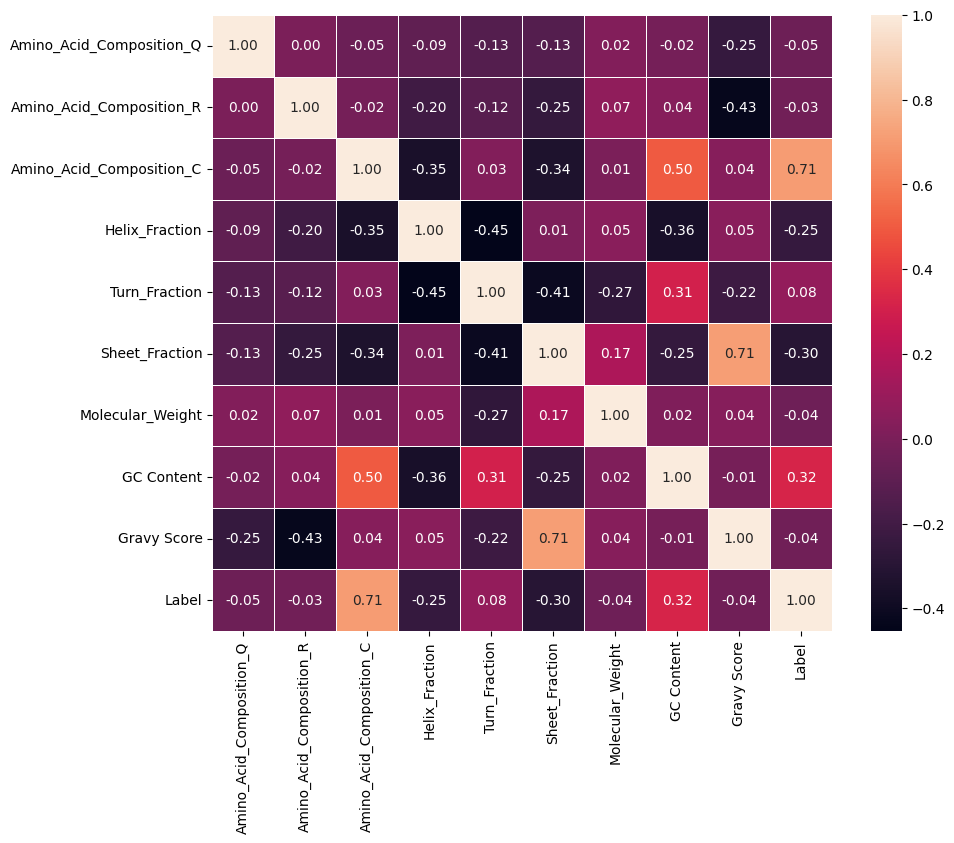

In [86]:
cor = data.corr()
plt.figure(figsize=(10,8), dpi =100)
sns.heatmap(cor,annot=True,fmt=".2f", linewidth=.5)
plt.show()

In [101]:
class_counts = data['Label'].value_counts()

fig = px.bar(x=class_counts.index, y=class_counts.values, labels={'x': 'Label', 'y': 'Count'},
             title='Imbalanced Classes Distribution', text=class_counts.values, height=400)

fig.show()

In [42]:
data_array = df_train.drop('Label', axis=1).to_numpy()
labels = df_train['Label'].to_numpy()

#Splitting the data
X_train, X_test, y_train, y_test = train_test_split(data_array, labels, test_size=0.2, random_state=42, shuffle=True)

#Standard scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#Model Selection

In [45]:
models = {"DecisionTree":DecisionTreeClassifier(),
         "RandomForest":RandomForestClassifier(),
         "XgBoost": XGBClassifier(),
         "KNeighborsClassifier":KNeighborsClassifier()}

def model_acc(models, X_train, X_test, y_train, y_test):
  acc = {}
  for model in models:
    mp = models[model]
    mp.fit(X_train, y_train)
    acc[model] = mp.score(X_test, y_test)
  return pd.DataFrame(acc, index = ['Test accuracy'] ).T

m_acc = model_acc(models, X_train, X_test, y_train, y_test)
m_acc.style.highlight_max()

,Test accuracy
DecisionTree,0.952620
RandomForest,0.967113
XgBoost,0.967670
KNeighborsClassifier,0.965440


In [46]:
m_acc = m_acc.reset_index().rename({"index":"Model"}, axis = 1)

fig = px.bar(data_frame = m_acc, x = 'Model', y = "Test accuracy", text = "Test accuracy", color = "Model", title = "<b>Models Accuracy</b>")
fig.update_yaxes(range=[0.9, 1])
fig.update_traces(width=0.5)

fig.show()

In [47]:
classifier = XGBClassifier()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

In [48]:
confusion_matrix(y_test, y_pred)

array([[3178,   47],
       [  69,  294]])

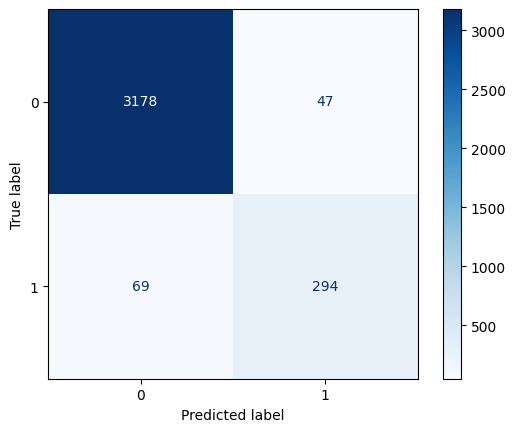

In [49]:
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap = plt.cm.Blues)

##Handling Imbalanced Data

###Technique 1. Moving Threshold
We need to change the threshold to the optimum value so that it can efficiently separate two classes. We're using a grid search method to identify the optimal value.

In [58]:
#We change the class boundary for prediction and store the threshold for best classification

step_factor = 0.05
threshold_value = 0.1
roc_score=0
predicted_proba = classifier.predict_proba(X_test)
while threshold_value <=0.8: #continue to check best threshold upto probability 0.8
    temp_thresh = threshold_value
    predicted = (predicted_proba [:,1] >= temp_thresh).astype('int')
    print('Threshold',temp_thresh,'--',roc_auc_score(y_test, predicted))
    if roc_score<roc_auc_score(y_test, predicted):
        roc_score = roc_auc_score(y_test, predicted)
        thrsh_score = threshold_value
    threshold_value = threshold_value + step_factor

print('---Optimum Threshold ---',thrsh_score,'--ROC--',roc_score)

Threshold 0.1 -- 0.9210993657505285
Threshold 0.15000000000000002 -- 0.9216003587673778
Threshold 0.2 -- 0.9191914920878981
Threshold 0.25 -- 0.9167646870395285
Threshold 0.3 -- 0.9138727657120892
Threshold 0.35 -- 0.91082580562496
Threshold 0.39999999999999997 -- 0.9056262412710615
Threshold 0.44999999999999996 -- 0.9001165993977833
Threshold 0.49999999999999994 -- 0.897671855980524
Threshold 0.5499999999999999 -- 0.8938497020949453
Threshold 0.6 -- 0.887582804792107
Threshold 0.65 -- 0.8793183419821897
Threshold 0.7000000000000001 -- 0.8742738163879813
Threshold 0.7500000000000001 -- 0.8614299442629253
---Optimum Threshold --- 0.15000000000000002 --ROC-- 0.9216003587673778


In [59]:
#So our threshold value changes from 0.5 to 0.15

####Hyperparameter Optimization

In [60]:
param_dist = {
     "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
}

In [61]:
optimized_XGB = RandomizedSearchCV(classifier,
                                   param_distributions=param_dist,
                                   n_iter=5,
                                   scoring='roc_auc',
                                   n_jobs=-1,
                                   cv=5, verbose=3)

In [62]:
optimized_XGB.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [3, 4, 5, 6, 8, 10, 12,
                                                      15],
                                        'min_child_weight': [1, 3, 5, 7]},
                   scoring='roc_auc', verbose=3)

In [63]:
xgb_best_params = optimized_XGB.best_estimator_

In [64]:
print(xgb_best_params)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)


In [65]:
optimized_XGB.best_score_

0.9732868703859193

In [68]:
val_data_array = df_val.drop('Label', axis=1).to_numpy()
val_labels = df_val['Label'].to_numpy()
X_val, X_valtest, y_val, y_valtest = train_test_split(data_array, labels, test_size=0.01, random_state=42, shuffle=True)

scaler = StandardScaler()
X_val = scaler.fit_transform(X_val)
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

X_val = X_val.reshape(17759, 9)

y_pred = (optimized_XGB.predict(X_val) > 0.15).astype("int32")
accuracy = accuracy_score(y_val, y_pred)
print(f'Test Accuracy: {accuracy:.4f}')

print(classification_report(y_val, y_pred))

Test Accuracy: 0.9930
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15966
           1       0.97      0.96      0.97      1793

    accuracy                           0.99     17759
   macro avg       0.98      0.98      0.98     17759
weighted avg       0.99      0.99      0.99     17759



####LSTM Model

In [70]:
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

model.fit(X_train, y_train, epochs=15, batch_size=64, validation_data=(X_test, y_test))

y_pred = (model.predict(X_test) > 0.15).astype("int32")
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy:.4f}')

print(classification_report(y_test, y_pred))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 64)             18944     
                                                                 
 dropout (Dropout)           (None, 1, 64)             0         
                                                                 
 batch_normalization (Batch  (None, 1, 64)             256       
 Normalization)                                                  
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                        

In [71]:
val_data_array = df_val.drop('Label', axis=1).to_numpy()
val_labels = df_val['Label'].to_numpy()
X_val, X_valtest, y_val, y_valtest = train_test_split(data_array, labels, test_size=0.01, random_state=42, shuffle=True)

scaler = StandardScaler()
X_val = scaler.fit_transform(X_val)
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

In [72]:
y_pred = (model.predict(X_val) > 0.15).astype("int32")
accuracy = accuracy_score(y_val, y_pred)
print(f'Test Accuracy: {accuracy:.4f}')

print(classification_report(y_val, y_pred))

555/555 [==============================] - 3s 5ms/step
Test Accuracy: 0.9644
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     15966
           1       0.79      0.89      0.83      1793

    accuracy                           0.96     17759
   macro avg       0.89      0.93      0.91     17759
weighted avg       0.97      0.96      0.97     17759



###Technique 2. Using BalancedBaggingClassifier to add addictional bagging


In [ ]:
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.tree import DecisionTreeClassifier
#Create an instance
classifier = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                sampling_strategy='not majority',
                                replacement=False,
                                random_state=42)
classifier.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_bagging.py:353: FutureWarning:

`base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.



BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                          random_state=42, sampling_strategy='not majority')

In [ ]:
val_data_array = df_val.drop('Label', axis=1).to_numpy()
val_labels = df_val['Label'].to_numpy()
X_val, X_valtest, y_val, y_valtest = train_test_split(data_array, labels, test_size=0.01, random_state=42, shuffle=True)

scaler = StandardScaler()
X_val = scaler.fit_transform(X_val)
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

X_val = X_val.reshape(17759, 9)

y_pred = (classifier.predict(X_val) > 0.5).astype("int32")
accuracy = accuracy_score(y_val, y_pred)
print(f'Test Accuracy: {accuracy:.4f}')

print(classification_report(y_val, y_pred))

Test Accuracy: 0.9883
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     15966
           1       0.97      0.92      0.94      1793

    accuracy                           0.99     17759
   macro avg       0.98      0.96      0.97     17759
weighted avg       0.99      0.99      0.99     17759



#Evaluation

In [77]:
m_acc = pd.DataFrame.from_dict({"Models": ['Optimized_XGBoost', 'LSTM'], "Accuracy":[99.3, 96.44]})

fig = px.bar(data_frame = m_acc, x = 'Models', y = "Accuracy", text = "Accuracy", color = "Models", title = "<b>Models Accuracy after Moving Threshold</b>")
fig.update_yaxes(range=[90, 100])
fig.update_traces(width=0.5)

fig.show()

In [78]:
m_acc = pd.DataFrame.from_dict({"Models": ['Optimized_XGBoost after moving threshold', 'Balanced Bagging classifier model'], "Accuracy":[99.3, 98.83]})

fig = px.bar(data_frame = m_acc, x = 'Models', y = "Accuracy", text = "Accuracy", color = "Models", title = "<b>Models Accuracy with different data handling methods</b>")
fig.update_yaxes(range=[90, 100])
fig.update_traces(width=0.5)

fig.show()